# The utilization of BEIJING site
This code will read from job archive table in ES and ...

In [1]:
%matplotlib inline
import datetime
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import time
from pandas.plotting import table
import os

from elasticsearch import Elasticsearch, helpers


last_days=7
avail_cpu=456
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')

indices = sorted(indices)
indices = [x for x in indices if x != '' and not x.endswith('_reindexed')]
#print(indices)
def time_filter(indices, last_days=1):
    if last_days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

ind = time_filter(indices, last_days)
print ("number of indices:", len(ind))
#print(ind)
ind = ','.join(ind)
#print(ind)
etime=int(time.time()*1000)
stime=etime-3600*24*last_days*1000
true="true"
false="false"
my_query={
  "size": 0,
  "version": true,
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "modificationhost:(/.*lwn1[2-4][0-9].ihep.ac.cn/ OR /.*lwn15[0-2].ihep.ac.cn/ )",
            "analyze_wildcard": true,
            "lowercase_expanded_terms": false
          }
        },
        {
          "range": {
            "modificationtime": {
              "gte": stime,
              "lte": etime,
              "format": "epoch_millis"
            }
          }
        }
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "terms": {
        "field": "computingsite",
        "size": 10,
        "order": {
          "_term": "desc"
        }
      },
      "aggs": {
        "4": {
          "terms": {
            "field": "jobstatus",
            "size": 5,
            "order": {
              "_count": "desc"
            }
          },
          "aggs": {
            "5": {
              "sum": {
                "script": {
                  "inline": "double core=doc['actualcorecount'].value; double wall_time=doc['wall_time'].value;if (core>0) {return (wall_time * core)/(3600*24)} else {return (wall_time)/(3600*24)}",
                  "lang": "painless"
                }
              }
            },
            "6": {
              "sum": {
                "script": {
                  "inline": "double max_cpu_per_event=2000;double cpusec=doc['cpuconsumptiontime'].value; String site=doc['computingsite'].value;double nevents=doc[\"nevents\"].value;if (site==\"BOINC_MCORE\" && (cpusec>max_cpu_per_event*nevents || cpusec<0)) {return max_cpu_per_event*nevents/(3600*24)} else {return cpusec/(3600*24)}",
                  "lang": "painless"
                }
              }
            }
          }
        }
      }
    }
  },
  "_source": {
    "excludes": []
  },
  "highlight": {
    "pre_tags": [
      "@kibana-highlighted-field@"
    ],
    "post_tags": [
      "@/kibana-highlighted-field@"
    ],
    "fields": {
      "*": {
        "highlight_query": {
          "bool": {
            "must": [
              {
                "query_string": {
                  "query": "modificationhost:(/.*lwn1[2-4][0-9].ihep.ac.cn/ OR /.*lwn15[0-2].ihep.ac.cn/ )",
                  "analyze_wildcard": true,
                  "lowercase_expanded_terms": false,
                  "all_fields": true
                }
              },
              {
                "range": {
                  "modificationtime": {
                    "gte": stime,
                    "lte": etime,
                    "format": "epoch_millis"
                  }
                }
              }
            ],
            "must_not": []
          }
        }
      }
    },
    "fragment_size": 2147483647
  }
}
res = es.search(index=ind, body=my_query, request_timeout=12000)

site_res={}
status_key=["finished","failed"]
metric_key=["cn","cputime","walltime"]
for metric in metric_key:
    for status in status_key:
        site_res[metric+"_"+status]={}
    
buckets=res['aggregations']['2']['buckets']


for i in range(len(buckets)):
    sitename=buckets[i]['key']
    #site_res[sitename]={}
    bs=buckets[i]["4"]["buckets"]
    for j in range(len(bs)):
        status=bs[j]['key']
        if status not in status_key:
            continue
        walltime=np.round(bs[j]['5']["value"]/last_days,0)
        cputime=np.round(bs[j]['6']["value"]/last_days,0)
        cn=np.round(bs[j]['doc_count']/last_days,0)
        #site_res[sitename]["cputime_"+status]=cputime
        #site_res[sitename]["walltime_"+status]=walltime
        #site_res[sitename]["cn_"+status]=cn
        site_res["cputime_"+status][sitename]=cputime
        site_res["walltime_"+status][sitename]=walltime
        site_res["cn_"+status][sitename]=cn
     
#print(site_res)

number of indices: 7


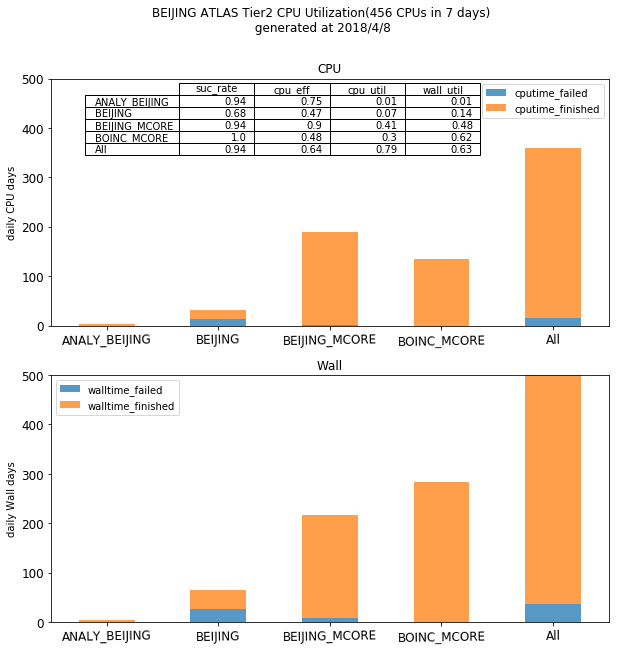

In [2]:
df=pd.DataFrame(site_res)
df["suc_rate"]=np.round(df["cn_finished"]/(df["cn_failed"]+df["cn_finished"]),2)
df["cpu_eff"]=np.round(df["cputime_finished"]/df["walltime_finished"],2)
df["cpu_util"]=np.round((df["cputime_finished"]+df["cputime_failed"])/avail_cpu,2)
df["wall_util"]=np.round((df["walltime_finished"]+df["walltime_failed"])/avail_cpu,2)

#print(df)
total_cpu_util=df["cpu_util"].sum()
avg_cn_rate=np.round(df["cn_finished"].sum()/(df["cn_failed"].sum()+df["cn_finished"].sum()),2)
avg_cpu_eff=np.round(df["cputime_finished"].sum()/df["walltime_finished"].sum(),2)
grid_wall_util=np.round((df["walltime_finished"]["ANALY_BEIJING":"BEIJING_MCORE"].sum()+df["walltime_failed"]["ANALY_BEIJING":"BEIJING_MCORE"].sum())/avail_cpu,2)
#print(avg_cn_rate,total_cpu_util,avg_cpu_eff,grid_wall_util)
all_walltime_finished=df["walltime_finished"].sum()
all_walltime_failed=df["walltime_failed"].sum()
all_cputime_finished=df["cputime_finished"].sum()
all_cputime_failed=df["cputime_failed"].sum()


tmp={"suc_rate":{"All":avg_cn_rate},"cpu_eff":{"All":avg_cpu_eff},"cpu_util":{"All":total_cpu_util},"wall_util":{"All":grid_wall_util},"cputime_finished":{"All":all_cputime_finished},"cputime_failed":{"All":all_cputime_failed},"walltime_finished":{"All":all_walltime_finished},"walltime_failed":{"All":all_walltime_failed}}
df=pd.concat([df,pd.DataFrame(tmp)])



dfes=[df[["cputime_failed","cputime_finished"]],df[["walltime_failed","walltime_finished"]],df[["suc_rate","cpu_eff","cpu_util","wall_util"]]]

l=time.localtime()[0:3]
today="/".join(map(str,l))

fig, axes = plt.subplots(2,1)
plt.suptitle("BEIJING ATLAS Tier2 CPU Utilization(%d CPUs in %d days)\n generated at %s"%(avail_cpu,last_days,today))
for i in [0,1]:
    tag="Wall"
    if i==0:
        tag="CPU"
       
    dfes[i].plot(ax=axes[i],kind="bar",stacked=True,grid=False,figsize=(10,10),rot=1,fontsize=12,title=tag,alpha=0.75,ylim=(0,500))
    if i==0:
         table(axes[i],dfes[2],loc="upper center",colWidths=[0.135]*len(dfes[2].columns),fontsize=12)
    #dfes[i].plot()
    #axes[i].set_xlabel("PanDA Queue")
    axes[i].set_ylabel("daily %s days"%tag)
    #ax.get_xaxis().set_visible(False)

fig.savefig("beijing_site_%s.png"%last_days)
